- BatchNormalization
- Resnet, Senet
- Hyperparameter Tuning
- retrain different layers
- mixed precision tests

In [2]:
import tensorflow as tf
from tensorflow import keras
print(tf.keras.__version__)
print(tf.__version__)
tf.config.list_physical_devices('GPU')
#keras.mixed_precision.set_global_policy("mixed_float16") # turn on mixed precision for faster computation

2.12.0
2.12.0


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [5]:
train_img_dir = '/home/lndr/Development/FER/AffectNet_sorted/train_set'
test_img_dir = '/home/lndr/Development/FER/AffectNet_sorted/val_set'
#train_img_dir = '/home/lndr/Development/FER/AffectNet_sorted_balanced_small/train_set'
#test_img_dir = '/home/lndr/Development/FER/AffectNet_sorted_balanced_small/val_set'

In [ ]:
# calculate weights on class distribution from 0-7

class_distribution = []

In [6]:
import random

def load_data(train_img_dir, test_img_dir):

    train_dataset = tf.keras.utils.image_dataset_from_directory(
        train_img_dir,
        labels='inferred',
        label_mode='int',
        color_mode='rgb',
        batch_size=32,
        image_size=(224, 224),
        shuffle=True,
        seed=random.randint(0,1000),
        validation_split=0.2,
        subset='both'
    )

    test_dataset = tf.keras.utils.image_dataset_from_directory(
        test_img_dir,
        labels='inferred',
        label_mode='int',
        color_mode='rgb',
        batch_size=32,
        image_size=(224, 224),
        shuffle=True,
        seed=random.randint(0,1000),
        validation_split=None
    )

    return train_dataset, test_dataset

---

In [4]:
from tensorflow.keras import layers
from keras_vggface.vggface import VGGFace

# Define Data Augmentation Layer
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        #layers.RandomZoom(0.2),
    ]
)

# Load Base Model
vgg_model = VGGFace(model="resnet50", include_top=False, input_shape=(224, 224, 3))
vgg_model.trainable = True
for layer in vgg_model.layers[:-33]:
    layer.trainable = False
    
# Add Head Model (Finetune)
inputs = keras.Input(shape=(224, 224, 3))
#x = data_augmentation(inputs)
x = keras.applications.resnet.preprocess_input(inputs)
x = vgg_model(x)
x = layers.Flatten(name='flatten')(x)
x = layers.Dense(512, activation="relu")(x)
#x = layers.Dropout(0.5)(x)
outputs = layers.Dense(8, activation='softmax', name='classifier', dtype="float32")(x) # opt-out mixed precision for softmax layer
model = keras.Model(inputs, outputs)


vgg_model.summary()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss = "sparse_categorical_crossentropy",
              metrics = ["accuracy"])

# Load dataset
(train_dataset, val_dataset), test_dataset = load_data(train_img_dir, test_img_dir)

from datetime import datetime
now = datetime.today()
current_time = now.strftime("%Y%m%d_%H-%M")
model_name = f"{current_time}_fer_finetuning_vggFace.keras"

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath=model_name,
        save_best_only=True,
        monitor="val_loss"),
    keras.callbacks.EarlyStopping(
        monitor="val_loss", 
        patience=10)
]

# fit model
print(f'Saving model as: {model_name}')
history = model.fit(x=train_dataset, epochs=50, validation_data=val_dataset, callbacks=callbacks)

Model: "vggface_resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1/7x7_s2 (Conv2D)          (None, 112, 112, 64  9408        ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 conv1/7x7_s2/bn (BatchNormaliz  (None, 112, 112, 64  256        ['conv1/7x7_s2[0][0]']           
 ation)                         )                                                  

                                                                                                  
 conv2_3_1x1_increase (Conv2D)  (None, 55, 55, 256)  16384       ['activation_57[0][0]']          
                                                                                                  
 conv2_3_1x1_increase/bn (Batch  (None, 55, 55, 256)  1024       ['conv2_3_1x1_increase[0][0]']   
 Normalization)                                                                                   
                                                                                                  
 add_18 (Add)                   (None, 55, 55, 256)  0           ['conv2_3_1x1_increase/bn[0][0]',
                                                                  'activation_55[0][0]']          
                                                                                                  
 activation_58 (Activation)     (None, 55, 55, 256)  0           ['add_18[0][0]']                 
          

 add_21 (Add)                   (None, 28, 28, 512)  0           ['conv3_3_1x1_increase/bn[0][0]',
                                                                  'activation_64[0][0]']          
                                                                                                  
 activation_67 (Activation)     (None, 28, 28, 512)  0           ['add_21[0][0]']                 
                                                                                                  
 conv3_4_1x1_reduce (Conv2D)    (None, 28, 28, 128)  65536       ['activation_67[0][0]']          
                                                                                                  
 conv3_4_1x1_reduce/bn (BatchNo  (None, 28, 28, 128)  512        ['conv3_4_1x1_reduce[0][0]']     
 rmalization)                                                                                     
                                                                                                  
 activatio

                                                                                                  
 activation_76 (Activation)     (None, 14, 14, 1024  0           ['add_24[0][0]']                 
                                )                                                                 
                                                                                                  
 conv4_3_1x1_reduce (Conv2D)    (None, 14, 14, 256)  262144      ['activation_76[0][0]']          
                                                                                                  
 conv4_3_1x1_reduce/bn (BatchNo  (None, 14, 14, 256)  1024       ['conv4_3_1x1_reduce[0][0]']     
 rmalization)                                                                                     
                                                                                                  
 activation_77 (Activation)     (None, 14, 14, 256)  0           ['conv4_3_1x1_reduce/bn[0][0]']  
          

                                                                                                  
 conv4_6_1x1_reduce/bn (BatchNo  (None, 14, 14, 256)  1024       ['conv4_6_1x1_reduce[0][0]']     
 rmalization)                                                                                     
                                                                                                  
 activation_86 (Activation)     (None, 14, 14, 256)  0           ['conv4_6_1x1_reduce/bn[0][0]']  
                                                                                                  
 conv4_6_3x3 (Conv2D)           (None, 14, 14, 256)  589824      ['activation_86[0][0]']          
                                                                                                  
 conv4_6_3x3/bn (BatchNormaliza  (None, 14, 14, 256)  1024       ['conv4_6_3x3[0][0]']            
 tion)                                                                                            
          

 activation_95 (Activation)     (None, 7, 7, 512)    0           ['conv5_3_1x1_reduce/bn[0][0]']  
                                                                                                  
 conv5_3_3x3 (Conv2D)           (None, 7, 7, 512)    2359296     ['activation_95[0][0]']          
                                                                                                  
 conv5_3_3x3/bn (BatchNormaliza  (None, 7, 7, 512)   2048        ['conv5_3_3x3[0][0]']            
 tion)                                                                                            
                                                                                                  
 activation_96 (Activation)     (None, 7, 7, 512)    0           ['conv5_3_3x3/bn[0][0]']         
                                                                                                  
 conv5_3_1x1_increase (Conv2D)  (None, 7, 7, 2048)   1048576     ['activation_96[0][0]']          
          

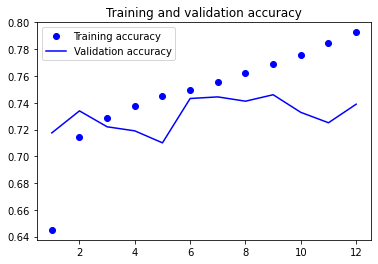

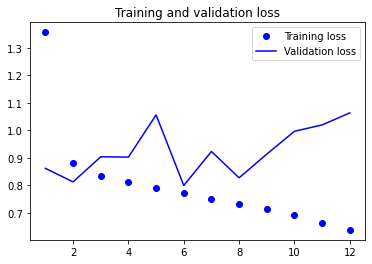

In [19]:
# complete dataset
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)

plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()

plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [9]:
# complete dataset
# adam, 1e-3, :-33 layer, epoch 2/50, no-dropout
model = keras.models.load_model(model_name)
print(f"Evaluating: {model_name}")
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

Evaluating: 20230712_18-15_fer_finetuning_vggFace.keras
125/125 [==============================] - 6s 46ms/step - loss: 1.6278 - accuracy: 0.4681
Test accuracy: 0.468


In [14]:
# complete dataset
# adam, 1e-3, feature-ext
model = keras.models.load_model(model_name)
print(f"Evaluating: {model_name}")
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

Evaluating: 20230712_11-59_fer_finetuning_vggFace.keras
125/125 [==============================] - 6s 47ms/step - loss: 2.1158 - accuracy: 0.4064
Test accuracy: 0.406
